# Image viewer

This notebook is for inspecting timelapse microscopy data, with associated sinhgle-cell labels and tracks, showing the infection of human macrophages with Mycobacterium Tuberculosis (Mtb), acquired on an Opera Phenix confocal microscope. 

In [30]:
import napari
from macrohet import dataio, tile, visualise
import btrack
print(btrack.__version__)
import os
import json 
from tqdm.auto import tqdm

scale_factor = 5.04
ndim = 2

0.6.1.dev30


In [2]:
napari.__version__

'0.4.17'

In [68]:
metadata.AbsTime

0          2021-04-16T19:09:33.84+01:00
1          2021-04-16T19:09:33.84+01:00
2          2021-04-16T19:09:34.12+01:00
3          2021-04-16T19:09:34.12+01:00
4           2021-04-16T19:09:34.4+01:00
                      ...              
113395    2021-04-19T21:14:19.477+01:00
113396    2021-04-19T21:14:19.757+01:00
113397    2021-04-19T21:14:19.757+01:00
113398    2021-04-19T21:14:20.037+01:00
113399    2021-04-19T21:14:20.037+01:00
Name: AbsTime, Length: 113400, dtype: object

In [71]:
images.shape

(75, 2, 6048, 6048)

### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [3]:
base_dir = '/mnt/DATA/macrohet/'
# base_dir = '/Volumes/lab-gutierrezm/home/users/dayn/macrohet_nemo/'
metadata_fn = os.path.join(base_dir, 'macrohet_images/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


id State                              URL Row Col FieldID  \
0        0303K1F1P1R1    Ok   r03c03f01p01-ch1sk1fk1fl1.tiff   3   3       1   
1        0303K1F1P1R2    Ok   r03c03f01p01-ch2sk1fk1fl1.tiff   3   3       1   
2        0303K1F1P2R1    Ok   r03c03f01p02-ch1sk1fk1fl1.tiff   3   3       1   
3        0303K1F1P2R2    Ok   r03c03f01p02-ch2sk1fk1fl1.tiff   3   3       1   
4        0303K1F1P3R1    Ok   r03c03f01p03-ch1sk1fk1fl1.tiff   3   3       1   
...               ...   ...                              ...  ..  ..     ...   
113395  0609K75F9P1R2    Ok  r06c09f09p01-ch2sk75fk1fl1.tiff   6   9       9   
113396  0609K75F9P2R1    Ok  r06c09f09p02-ch1sk75fk1fl1.tiff   6   9       9   
113397  0609K75F9P2R2    Ok  r06c09f09p02-ch2sk75fk1fl1.tiff   6   9       9   
113398  0609K75F9P3R1    Ok  r06c09f09p03-ch1sk75fk1fl1.tiff   6   9       9   
113399  0609K75F9P3R2    Ok  r06c09f09p03-ch2sk75fk1fl1.tiff   6   9       9   

       PlaneID TimepointID ChannelID FlimID  ... PositionZ AbsPositionZ  \
0            1           0         1      1  ...         0  0.135583505   
1            1           0         2      1  ...         0  0.135583505   
2            2           0         1      1  ...     2E-06  0.135585502   
3            2           0         2      1  ...     2E-06  0.135585502   
4            3           0         1      1  ...     4E-06  0.135587499   
...        ...         ...       ...    ...  ...       ...          ...   
113395       1          74         2      1  ...         0  0.135533601   
113396       2          74         1      1  ...     2E-06  0.135535598   
113397       2          74         2      1  ...     2E-06  0.135535598   
113398       3          74         1      1  ...     4E-06  0.135537595   
113399       3          74         2      1  ...     4E-06  0.135537595   

       MeasurementTimeOffset                        AbsTime  \
0                          0   2021-04-16T19:09:33.84+01:00   
1                          0   2021-04-16T19:09:33.84+01:00   
2                          0   2021-04-16T19:09:34.12+01:00   
3                          0   2021-04-16T19:09:34.12+01:00   
4                          0    2021-04-16T19:09:34.4+01:00   
...                      ...                            ...   
113395             266399.61  2021-04-19T21:14:19.477+01:00   
113396             266399.61  2021-04-19T21:14:19.757+01:00   
113397             266399.61  2021-04-19T21:14:19.757+01:00   
113398             266399.61  2021-04-19T21:14:20.037+01:00   
113399             266399.61  2021-04-19T21:14:20.037+01:00   

       MainExcitationWavelength MainEmissionWavelength ObjectiveMagnification  \
0                           488                    522                     40   
1                           640                    706                     40   
2                           488                    522                     40   
3                           640                    706                     40   
4                           488                    522                     40   
...                         ...                    ...                    ...   
113395                      640                    706                     40   
113396                      488                    522                     40   
113397                      640                    706                     40   
113398                      488                    522                     40   
113399                      640                    706                     40   

       ObjectiveNA ExposureTime  \
0              1.1          0.1   
1              1.1          0.2   
2              1.1          0.1   
3              1.1          0.2   
4              1.1          0.1   
...            ...          ...   
113395         1.1          0.2   
113396         1.1          0.1   
113397         1.1          0.2   
113398         1.1          0.1   
113399         1.1          0.2   

      

### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [4]:
metadata_path = os.path.join(base_dir, 'macrohet_images/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

### Define row and column of choice

In [5]:
row = 3
column = 6

### Now to lazily mosaic the images using Dask prior to viewing them.

1x (75,2,3) [TCZ] image stack takes approximately 1 minute to stitch together, so only load the one field of view I want.

In [6]:
image_dir = os.path.join(base_dir, 'macrohet_images/Images_8bit')
images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, column, 
                             set_plane='sum_proj',
#                              set_channel=1,
#                              set_time = 66,
#                             input_transforms = [input_transforms]
                            )#.compute().compute()

In [72]:
 tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, column, 
                             set_plane='sum_proj',
#                              set_channel=1,
#                              set_time = 66,
#                             input_transforms = [input_transforms]
                            )#.compute().compute()

dask.array<astype, shape=(75, 2, 6048, 6048), dtype=uint8, chunksize=(1, 2, 2016, 2016), chunktype=numpy.ndarray>

In [7]:
%%time
images = images.compute().compute()

CPU times: user 2h 52min 39s, sys: 17min 4s, total: 3h 9min 44s
Wall time: 7min 9s


In [8]:
images.shape

(75, 2, 6048, 6048)

# Load tracks

In [9]:
tracks_fn = os.path.join(base_dir, f'labels/macrohet_seg_model/{row, column}.h5')
with btrack.io.HDF5FileHandler(tracks_fn, 'r') as hdf:
    tracks = hdf.tracks
    segmentation = hdf.segmentation
napari_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks, ndim=ndim)

[INFO][2023/07/10 01:23:23 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 6).h5...
[INFO][2023/07/10 01:23:23 PM] Loading tracks/obj_type_1
[INFO][2023/07/10 01:23:23 PM] Loading LBEP/obj_type_1
[INFO][2023/07/10 01:23:23 PM] Loading objects/obj_type_1 (46507, 5) (46507 filtered: None)
[INFO][2023/07/10 01:23:33 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/07/10 01:23:33 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 6).h5


### Filter tracks? 

In [12]:
filtered_tracks, properties, graph = btrack.utils.tracks_to_napari(
                                                                    [t for t in tracks if len(t) > 10], 
                                                                    ndim=2)

### Recolour segmentation

In [14]:
col_segmentation = btrack.utils.update_segmentation(segmentation, tracks, scale = (scale_factor,)*ndim)

# Launch napari image viewer

In [45]:
viewer = napari.Viewer()

viewer.add_image(images, 
                 channel_axis=1,
                 name=["macrophage", "mtb"],
                 colormap=["green",  "magenta"],
#                  contrast_limits=[[100, 6000], [100, 2000]],
                 contrast_limits=[[0,450], [0,450]], 
                 visible = True
                 )
viewer.add_labels(segmentation, 
#                   num_colors= 1,
                  #scale=(10, 1, 1,), 
                  #color='yellow'
                  name = 'segmentation'
                 )
viewer.add_labels(col_segmentation, 
                  name = 'recolored segmentation'
                  #scale=(10, 1, 1,), 
                  #color='yellow'
                 )
viewer.add_tracks(napari_tracks, scale = (1,scale_factor,scale_factor)
#                     properties=properties, 
#                     graph=graph, 
#                     name="Properly downscaled tracks", 
#                     blending="translucent",
#                     visible=True,
# #                     scale = (100,1,1)
                 )
viewer.add_tracks(filtered_tracks, scale = (1,scale_factor,scale_factor)
#                     properties=properties, 
#                     graph=graph, 
#                     name="Properly downscaled tracks", 
#                     blending="translucent",
#                     visible=True,
# #                     scale = (100,1,1)
                 )

<Tracks layer 'filtered_tracks' at 0x7fbcf73d6190>

In [47]:
visualise.add_napari_grid_overlay(viewer)

<Shapes layer 'grid_lines [1]' at 0x7fbcfa0df100>

### Functions to record ground truth tracks

Napari key bindings that record which tracks are True and which are False

In [25]:
track_performance_dir = f'/mnt/DATA/macrohet/upstream_development/tracking/tracking_performance/{row},{column}/'
os.makedirs(track_performance_dir, exist_ok=True)
track_performance_dict = dict()

# Update layers rather than create new points layer for each instance

In [49]:
@viewer.bind_key("z", overwrite=True)
def true_track(viewer):
    """
    Marks a track as true based on the cursor position in the Napari viewer.

    Parameters
    ----------
    viewer : napari.viewer.Viewer
        The Napari viewer instance.

    """
    # Scale the coordinates for the tracks layer
    scaled_coords = [viewer.cursor.position[0]] + [coord / scale_factor for coord in viewer.cursor.position[1:]]

    # Use scaled coords to extract track ID under cursor
    cell_ID = viewer.layers['napari_tracks'].get_value(scaled_coords)

    if not cell_ID:
        print('cell ID not found')
    else:
        # Add track label to track_dict
        track_performance_dict[int(cell_ID)] = True

        with open(os.path.join(track_performance_dir, f'{row, column}_track_assessment.json'), "w") as file:
            json.dump(track_performance_dict, file)

        print(f"{cell_ID}:True")

    track = [track for track in tracks if track.ID == cell_ID][0]
    points = [[track.t[i], track.y[i] * scale_factor, track.x[i] * scale_factor] for i in range(len(track))]
    name = 'true tracks'

    try:
        # If the layer exists, add the points
        viewer.layers[name].add(points)
    except:
        # If the layer does not exist, create a new layer
        viewer.add_points(points,
                          size=100,
                          symbol='star',
                          face_color='transparent',
                          edge_color='white',
                          edge_width=0.1,
                          name=name,
                          opacity=0.3
                          # scale=napari_scale
                          )


@viewer.bind_key("x", overwrite=True)
def false_track(viewer):
    """
    Marks a track as false based on the cursor position in the Napari viewer.

    Parameters
    ----------
    viewer : napari.viewer.Viewer
        The Napari viewer instance.

    """
    # Scale the coordinates for the tracks layer
    scaled_coords = [viewer.cursor.position[0]] + [coord / scale_factor for coord in viewer.cursor.position[1:]]

    # Use scaled coords to extract track ID under cursor
    cell_ID = viewer.layers['napari_tracks'].get_value(scaled_coords)

    if not cell_ID:
        print('cell ID not found')
    else:
        # Add track label to track_dict
        track_performance_dict[int(cell_ID)] = False

        with open(os.path.join(track_performance_dir, f'{row, column}_track_assessment.json'), "w") as file:
            json.dump(track_performance_dict, file)

        print(f"{cell_ID}:False")

    track = [track for track in tracks if track.ID == cell_ID][0]
    points = [[track.t[i], track.y[i] * scale_factor, track.x[i] * scale_factor] for i in range(len(track))]
    name = 'false tracks'

    try:
        # If the layer exists, add the points
        viewer.layers[name].add(points)
    except:
        # If the layer does not exist, create a new layer
        viewer.add_points(points,
                          size=100,
                          symbol='x',
                          face_color='transparent',
                          edge_color='white',
                          edge_width=0.1,
                          name=name,
                          opacity=0.3
                          # scale=napari_scale
                          )


### Track linking key bindings

In [50]:
@viewer.bind_key("c", overwrite=True)
def link_init_track(viewer):
    """
    Initializes the linking of tracks based on the cursor position in the Napari viewer.

    Parameters
    ----------
    viewer : napari.viewer.Viewer
        The Napari viewer instance.

    """
    # Scale the coordinates for the tracks layer
    scaled_coords = [viewer.cursor.position[0]] + [coord / scale_factor for coord in viewer.cursor.position[1:]]

    # Use scaled coords to extract track ID under cursor
    cell_ID = viewer.layers['napari_tracks'].get_value(scaled_coords)

    track = [track for track in tracks if track.ID == cell_ID][0]
    points = [[track.t[i], track.y[i] * scale_factor, track.x[i] * scale_factor] for i in range(len(track))]
    name = 'to-be linked tracks'

    try:
        # If the layer exists, add the points
        viewer.layers[name].add(points)
    except:
        # If the layer does not exist, create a new layer
        viewer.add_points(points,
                          size=100,
                          symbol='tailed_arrow',
                          face_color='transparent',
                          edge_color='white',
                          edge_width=0.1,
                          name=name,
                          opacity=0.3
                          # scale=napari_scale
                          )

    global previous_ID
    previous_ID = cell_ID


@viewer.bind_key("v", overwrite=True)
def link_init_track(viewer):
    """
    Initializes the linking of tracks and updates the track performance dictionary based on the cursor position.

    Parameters
    ----------
    viewer : napari.viewer.Viewer
        The Napari viewer instance.

    """
    # Scale the coordinates for the tracks layer
    scaled_coords = [viewer.cursor.position[0]] + [coord / scale_factor for coord in viewer.cursor.position[1:]]

    # Use scaled coords to extract track ID under cursor
    cell_ID = viewer.layers['napari_tracks'].get_value(scaled_coords)

    if not cell_ID:
        print('cell ID not found')
    else:
        # Add track label to track_dict
        track_performance_dict[f'{previous_ID},{cell_ID}'] = 'Link'

        with open(os.path.join(track_performance_dir, f'{row, column}_track_assessment.json'), "w") as file:
            json.dump(track_performance_dict, file)

        print(f"{previous_ID},{cell_ID}:'Link'")

    track = [track for track in tracks if track.ID == cell_ID][0]
    points = [[track.t[i], track.y[i] * scale_factor, track.x[i] * scale_factor] for i in range(len(track))]
    name = 'to-be linked tracks'

    try:
        # If the layer exists, add the points
        viewer.layers[name].add(points)
    except:
        # If the layer does not exist, create a new layer
        viewer.add_points(points,
                          size=100,
                          symbol='tailed_arrow',
                          face_color='transparent',
                          edge_color='white',
                          edge_width=0.1,
                          name=name,
                          opacity=0.3
                          # scale=napari_scale
                          )

### Add previously annotated tracks

In [48]:
for cell_ID in tqdm(track_performance_dict.keys()):
    if track_performance_dict[cell_ID] == True:
        track = [track for track in tracks if track.ID == cell_ID][0]
        points = [[track.t[i], track.y[i] * scale_factor, track.x[i] * scale_factor] for i in range(len(track))]
        name = 'true tracks'
        try:
            # If it exists, add the points
            viewer.layers[name].add(points)
        except:
            # If it doesn't exist, create a new layer
            viewer.add_points(points, 
                              size=100,
                              symbol='star',
                              face_color='transparent',
                              edge_color='white',
                              edge_width=0.1,
                              name=name,
                              opacity=0.3
                              # scale=napari_scale
                              )
    elif track_performance_dict[cell_ID] == False:
        track = [track for track in tracks if track.ID == cell_ID][0]
        points = [[track.t[i], track.y[i] * scale_factor, track.x[i] * scale_factor] for i in range(len(track))]
        name = 'false tracks'
        try:
            # If it exists, add the points
            viewer.layers[name].add(points)
        except:
            # If it doesn't exist, create a new layer
            viewer.add_points(points, 
                              size=100,
                              symbol='x',
                              face_color='transparent',
                              edge_color='white',
                              edge_width=0.1,
                              name=name,
                              opacity=0.3
                              # scale=napari_scale
                              )
    else:
        cell_ID1 = int(cell_ID.split(',')[0])
        track = [track for track in tracks if track.ID == cell_ID1][0]
        points = [[track.t[i], track.y[i] * scale_factor, track.x[i] * scale_factor] for i in range(len(track))]
        name = 'to-be linked tracks'
        try:
            # If it exists, add the points
            viewer.layers[name].add(points)
        except:
            # If it doesn't exist, create a new layer
            viewer.add_points(points, 
                              size=100,
                              symbol='tailed_arrow',
                              face_color='transparent',
                              edge_color='white',
                              edge_width=0.1,
                              name=name,
                              opacity=0.3
                              # scale=napari_scale
                              )
            
        # Add second linked track
        cell_ID2 = int(cell_ID.split(',')[1])
        track = [track for track in tracks if track.ID == cell_ID2][0]
        points = [[track.t[i], track.y[i] * scale_factor, track.x[i] * scale_factor] for i in range(len(track))]
        name = 'to-be linked tracks'
        try:
            # If it exists, add the points
            viewer.layers[name].add(points)
        except:
            # If it doesn't exist, create a new layer
            viewer.add_points(points, 
                              size=100,
                              symbol='tailed_arrow',
                              face_color='transparent',
                              edge_color='white',
                              edge_width=0.1,
                              name=name,
                              opacity=0.3
                              # scale=napari_scale
                              )

  0%|          | 0/118 [00:00<?, ?it/s]

# Progress:

In [65]:
print()


1799:False
678:False
672:True
542:False
546:False
676:True
3278:True
3347:True
545,2140:'Link'
104,2901:'Link'
2901,3345:'Link'
2030:True
3276:True
119:True
96:True
3138:True
88,2093:'Link'
550:True
1228,3678:'Link'
517:True
112,1896:'Link'
795:True
3851:False
925,3447:'Link'
562:False
559:False
118:True
94:True
534:True
106:True
539:False
679:True
3932:True
2772:True
2774:True
123:True
147:False
2451:True
108,3114:'Link'
90:False
3429:True
2622:True
1210:True
544:True
558:False
2575:True
2518:True


In [52]:
# 5% takes 30 mins... 10 hours for one position? 

In [62]:
del track_performance_dict['752,1952']

1952,3170:'Link'
3170,4092:'Link'
506:True
548:True
508:True
525:True
2945:True
533,2437:'Link'
650:False
1843:False
3426:False
2392:True
1343:True
614:True
625,2811:'Link'
1074:True
2008:True
1207:True
1207:True
1081:True
630:True
499:True
516:True
595:False
526:False
894:True
1070:True
523:True
615:False
509:True
505:True
632,3653:'Link'
632:True
3333:False
2855:False
2123:False
2893:False
2936:False
3026,3757:'Link'
491,4053:'Link'
502,3376:'Link'
3660:False
4057:True
895:True
1848,3126:'Link'
1149:False
3957:False
3126,3708:'Link'
1568:True
519,3211:'Link'
3613:True
2438:True
494:True
2129:False
3840:False
2343:False
503:True


# Stats

In [514]:
output_dir = '/mnt/DATA/macrohet/upstream_development/tracking/tracking_performance/3,5/ground_truth_tracks'

In [293]:
track_performance_dict

{425: True,
 694: True,
 403: False,
 427: True,
 453: False,
 217: True,
 1002: False,
 1893: False,
 1986: False,
 2192: False,
 401: True,
 412: False,
 2499: False,
 1446: False,
 1003: True,
 790: False,
 1552: False,
 2862: False,
 432: True,
 456: True,
 461: True,
 416: True,
 1892: False,
 430: True,
 1226: True,
 1783: True,
 '429,2818': 'Link',
 431: True,
 407: True,
 '2675,404': 'Link',
 398: True,
 423: True,
 424: True,
 428: False,
 418: False,
 411: False,
 '411,1683': 'Link',
 1058: False,
 466: True,
 465: True,
 397: True,
 426: True,
 419: True,
 1735: True,
 420: True,
 421: True,
 802: True,
 455: False,
 406: False,
 410: True,
 '411,1118': 'Link',
 1118: True,
 '1114,2130': 'Link',
 414: True,
 459: True,
 2234: True,
 470: True,
 437: True,
 '1649,2453': 'Link',
 '2453,3126': 'Link',
 444: True,
 865: False,
 441: True,
 318: False,
 2952: False,
 1596: False,
 1650: False,
 442: False,
 339: True,
 '317,1432': 'Link',
 '1432,2223': 'Link',
 325: True,
 335: T

In [66]:
len(track_performance_dict)

458

In [64]:
correct_track_IDs = [key for key in track_performance_dict.keys() if track_performance_dict[key] == True]
print(len(correct_track_IDs))

false_track_IDs = [key for key in track_performance_dict.keys() if track_performance_dict[key] == False]
print(len(false_track_IDs))

linked_track_IDs = [key for key in track_performance_dict.keys() if track_performance_dict[key] == 'Link']
print(len(linked_track_IDs))

219
126
60


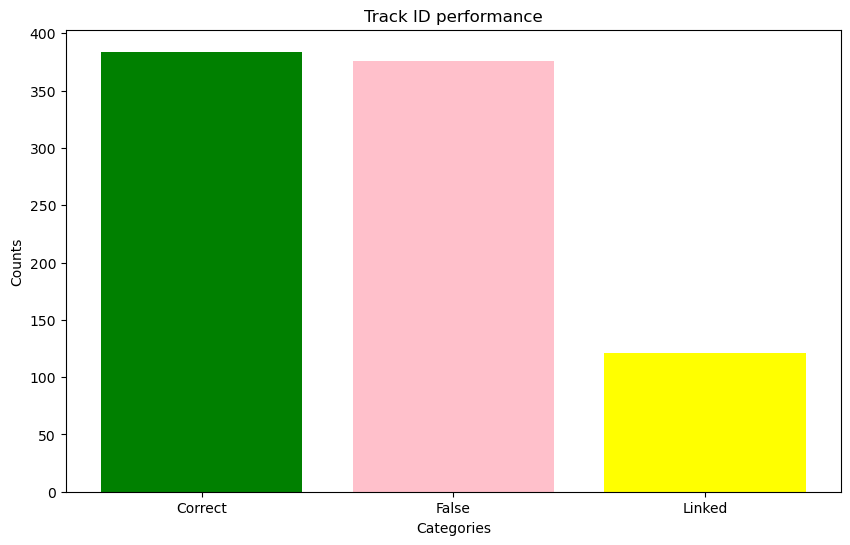

In [302]:
import matplotlib.pyplot as plt

# Assuming you have defined your track_performance_dict dictionary
correct_track_IDs = [key for key in track_performance_dict.keys() if track_performance_dict[key] == True]
false_track_IDs = [key for key in track_performance_dict.keys() if track_performance_dict[key] == False]
linked_track_IDs = [key for key in track_performance_dict.keys() if track_performance_dict[key] == 'Link']

# Get counts
counts = [len(correct_track_IDs), len(false_track_IDs), len(linked_track_IDs)]

# Prepare data
categories = ['Correct', 'False', 'Linked']
colors = ['green', 'pink', 'yellow']  # PIYG color scheme approximation 

# Plot
plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color=colors)
plt.title('Track ID performance')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.show()

/tmp/ipykernel_242561/3844886305.py:46: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(os.path.join(output_dir, 'track_performance_pie_chart_3,5_ground_truth.png'),


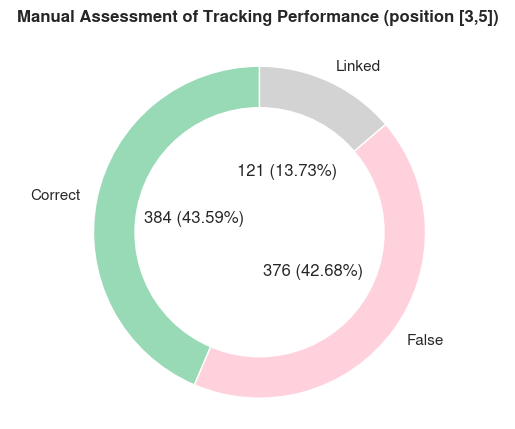

In [521]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set the theme and style
sns.set(font='Nimbus Sans', style='white')

# Assuming you have defined your track_performance_dict dictionary
correct_track_IDs = [key for key in track_performance_dict.keys() if track_performance_dict[key] == True]
false_track_IDs = [key for key in track_performance_dict.keys() if track_performance_dict[key] == False]
linked_track_IDs = [key for key in track_performance_dict.keys() if track_performance_dict[key] == 'Link']

# Get counts
counts = [len(correct_track_IDs), len(false_track_IDs), len(linked_track_IDs)]

# Prepare data
categories = ['Correct', 'False', 'Linked']
colors = ['#98d9b6', '#ffd1dc', '#d3d3d3']  # Adjusted color palette 

# Plot
fig, ax = plt.subplots()

# Define autopct function to move labels into the pie
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(v=val) + ' ({p:.2f}%)'.format(p=pct)
    return my_format

# Draw pie chart
ax.pie(counts, labels=categories, autopct=autopct_format(counts), startangle=90, pctdistance=0.4, colors=colors)

# Draw white circle in the middle for the "donut" style
centre_circle = plt.Circle((0,0),0.750,fc='white')
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')  

# Change the font to Helvetica (default font in Apple Keynote)
plt.rcParams['font.family'] = 'Helvetica'

plt.title('Manual Assessment of Tracking Performance (position [3,5])', pad=20, weight='bold')

plt.savefig(os.path.join(output_dir, 'track_performance_pie_chart_3,5_ground_truth.png'), 
            bbox_inches='tight', dpi=314)

plt.show()


In [291]:
total_len=0
for cell_ID in tqdm(track_performance_dict.keys()):
    if isinstance(cell_ID, str):
        cell_ID1 = int(cell_ID.split(',')[0])
        track_len1 = len([t for t in tracks if t.ID == cell_ID1][0])
        cell_ID2 = int(cell_ID.split(',')[1])
        track_len2 = len([t for t in tracks if t.ID == cell_ID2][0])
        track_len = track_len1+track_len2
    else:
        track_len = len([t for t in tracks if t.ID == cell_ID][0])
    total_len += track_len

  0%|          | 0/881 [00:00<?, ?it/s]

In [292]:
total_len


41784

# Creating heatmap for track quality

Correlate to density? Movement? etc.

/tmp/ipykernel_242561/556584416.py:34: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(os.path.join(output_dir, 'heatmap_correct_tracks_3,5_ground_truth.png'),


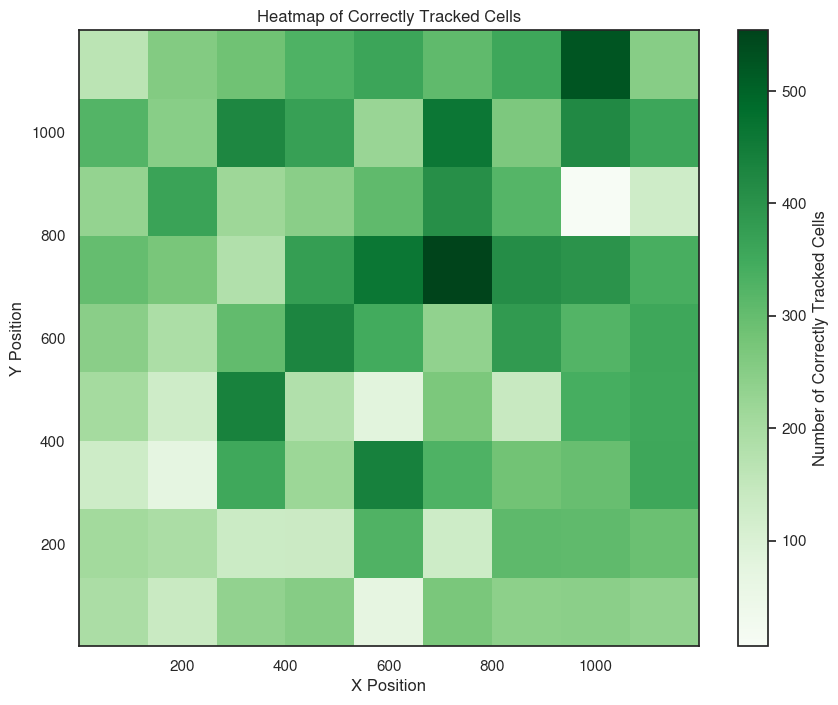

/tmp/ipykernel_242561/556584416.py:45: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(os.path.join(output_dir, 'heatmap_false_tracks_3,5_ground_truth.png'),


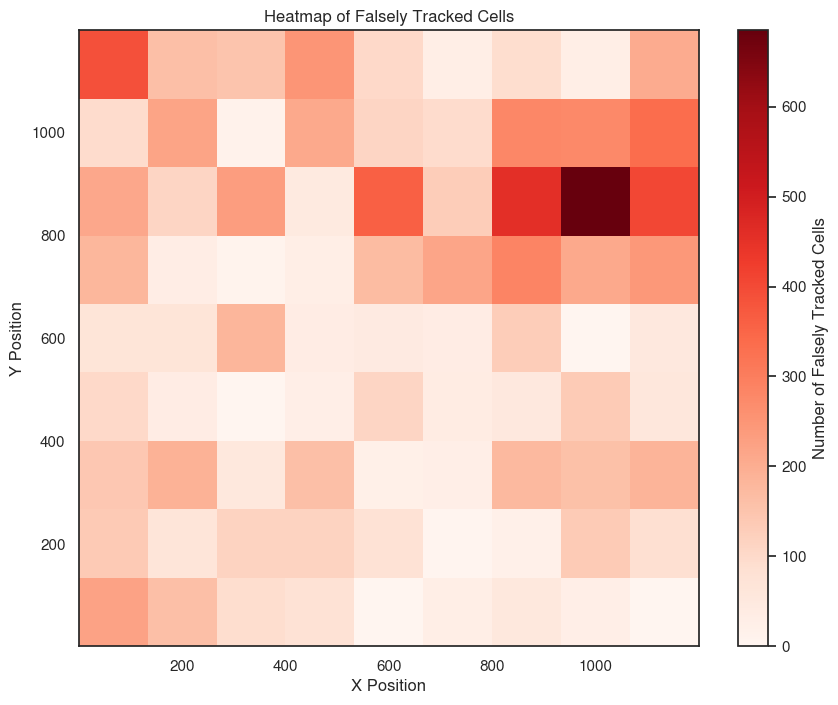

In [520]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set the theme
sns.set(font='Nimbus Sans', style='white')

correct_x, correct_y = [], []
false_x, false_y = [], []

for cell_ID in track_performance_dict.keys():
    if isinstance(cell_ID, str):
        continue
    track = [t for t in tracks if t.ID == int(cell_ID)][0]
    if track_performance_dict[cell_ID] == True:
        correct_x.extend(track.x)
        correct_y.extend(track.y)
    elif track_performance_dict[cell_ID] == False:
        false_x.extend(track.x)
        false_y.extend(track.y)

# Preparing the grid for the histogram
x_bins = np.linspace(min(min(correct_x), min(false_x)), max(max(correct_x), max(false_x)), 10)
y_bins = np.linspace(min(min(correct_y), min(false_y)), max(max(correct_y), max(false_y)), 10)

# Plotting the heatmap for correctly tracked cells
plt.figure(figsize=(10, 8))
plt.hist2d(correct_x, correct_y, bins=[x_bins, y_bins], cmap='Greens')
plt.colorbar(label='Number of Correctly Tracked Cells')
plt.title('Heatmap of Correctly Tracked Cells')
plt.xlabel('X Position')
plt.ylabel('Y Position')

plt.savefig(os.path.join(output_dir, 'heatmap_correct_tracks_3,5_ground_truth.png'), 
            bbox_inches='tight', dpi=314)
plt.show()

# Plotting the heatmap for falsely tracked cells
plt.figure(figsize=(10, 8))
plt.hist2d(false_x, false_y, bins=[x_bins, y_bins], cmap='Reds')
plt.colorbar(label='Number of Falsely Tracked Cells')
plt.title('Heatmap of Falsely Tracked Cells')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.savefig(os.path.join(output_dir, 'heatmap_false_tracks_3,5_ground_truth.png'), 
            bbox_inches='tight', dpi=314)

plt.show()


/tmp/ipykernel_242561/3368865273.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(os.path.join(output_dir, 'heatmap_cells_t0-10_3,5_ground_truth.png'),


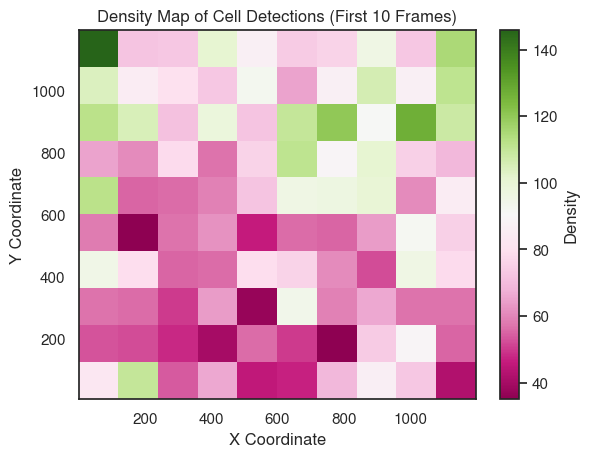

In [525]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font='Nimbus Sans', style='white')

# Get the first ten frames
frames = range(10)

# Filter tracks for the first ten frames
tracks_first_10_frames = [track for track in tracks if any(track.in_frame(frame) for frame in frames)]

# Get the x and y coordinates for the filtered tracks
x_coords = [coord for track in tracks_first_10_frames for coord in track.x[:10]]
y_coords = [coord for track in tracks_first_10_frames for coord in track.y[:10]]

# Create the density map using plt.hist2d()
heatmap, xedges, yedges, _ = plt.hist2d(x_coords, y_coords, bins=10, cmap='PiYG')
plt.colorbar(label='Density')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Density Map of Cell Detections (First 10 Frames)')


plt.savefig(os.path.join(output_dir, 'heatmap_cells_t0-10_3,5_ground_truth.png'), 
            bbox_inches='tight', dpi=314)

plt.show()


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/seaborn/distrib

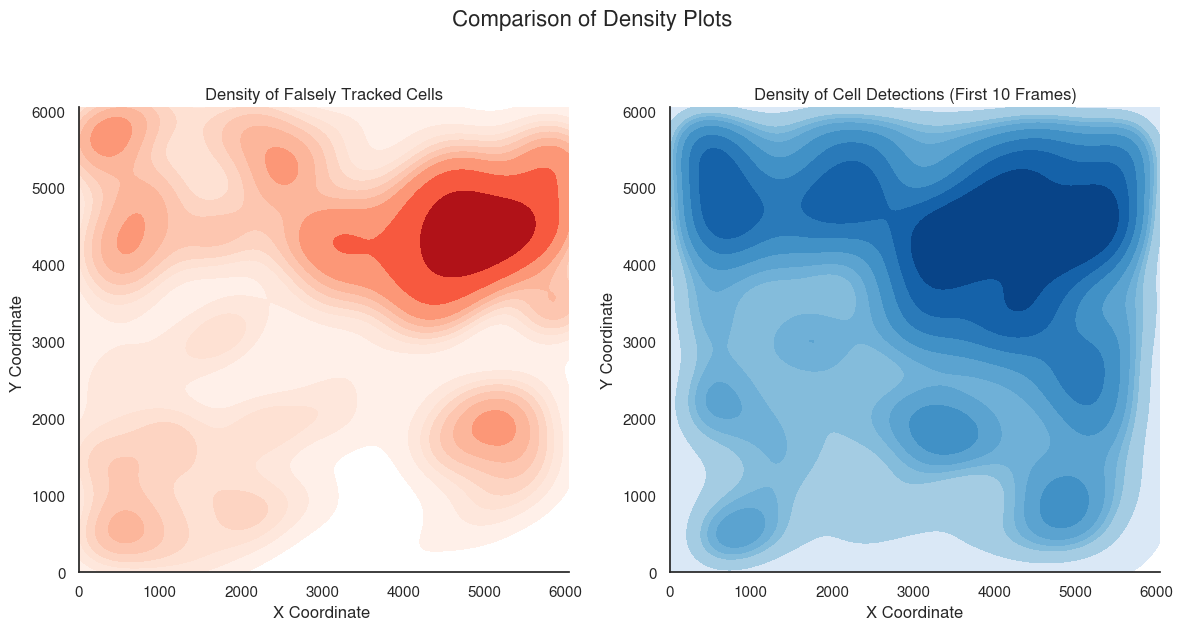

In [529]:
import matplotlib.pyplot as plt
import seaborn as sns


# Scale the x and y coordinates by 5.04
scaled_false_x = [coord * 5.04 for coord in false_x]
scaled_false_y = [coord * 5.04 for coord in false_y]

scaled_x_coords = [coord * 5.04 for coord in x_coords]
scaled_y_coords = [coord * 5.04 for coord in y_coords]

# Set the figure size for both plots
plt.figure(figsize=(12, 6))

# Plot the KDE density plot of falsely tracked cells
plt.subplot(1, 2, 1)  # Create the first subplot
sns.kdeplot(scaled_false_x, scaled_false_y, cmap='Reds', shade=True, shade_lowest=False)
plt.xlim(0, 1200 * 5.04)
plt.ylim(0, 1200 * 5.04)
plt.xlabel('X Coordinate ')
plt.ylabel('Y Coordinate ')
plt.title('Density of Falsely Tracked Cells')

# Plot the KDE density plot of cell detections (first 10 frames)
plt.subplot(1, 2, 2)  # Create the second subplot
sns.kdeplot(scaled_x_coords, scaled_y_coords, cmap='Blues', shade=True, shade_lowest=False)
plt.xlim(0, 1200 * 5.04)
plt.ylim(0, 1200 * 5.04)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Density of Cell Detections (First 10 Frames)')

# Share the same x and y labels
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Comparison of Density Plots', fontsize=16, y=1.05)

# Remove the spines
sns.despine()


plt.savefig(os.path.join(output_dir, 'density_false_tracks_cell_detec_0-10_3,5_ground_truth.png'), 
            bbox_inches='tight', dpi=314)
# Show the plot
plt.show()


In [530]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scale the x and y coordinates by 5.04
scaled_false_x = [coord * 5.04 for coord in correct_x]
scaled_false_y = [coord * 5.04 for coord in correct_y]

scaled_x_coords = [coord * 5.04 for coord in x_coords]
scaled_y_coords = [coord * 5.04 for coord in y_coords]

# Set the figure size for both plots
plt.figure(figsize=(12, 6))

# Plot the KDE density plot of falsely tracked cells
plt.subplot(1, 2, 1)  # Create the first subplot
sns.kdeplot(scaled_false_x, scaled_false_y, cmap='Greens', shade=True, shade_lowest=False)
plt.xlim(0, 1200 * 5.04)
plt.ylim(0, 1200 * 5.04)
plt.xlabel('X Coordinate ')
plt.ylabel('Y Coordinate ')
plt.title('Density of Correctly Tracked Cells')

# Plot the KDE density plot of cell detections (first 10 frames)
plt.subplot(1, 2, 2)  # Create the second subplot
sns.kdeplot(scaled_x_coords, scaled_y_coords, cmap='Blues', shade=True, shade_lowest=False)
plt.xlim(0, 1200 * 5.04)
plt.ylim(0, 1200 * 5.04)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Density of Cell Detections (First 10 Frames)')

# Share the same x and y labels
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Comparison of Density Plots', fontsize=16, y=1.05)

# Remove the spines
sns.despine()

plt.savefig(os.path.join(output_dir, 'density_true_tracks_cell_detec_0-10_3,5_ground_truth.png'), 
            bbox_inches='tight', dpi=314)
# Show the plot
plt.show()


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/seaborn/distrib

In [531]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lists to store the coordinates
correct_x, correct_y = [], []
infected_x, infected_y = [], []

# Iterate over the tracks and separate the coordinates based on track performance and infection status
for track in tracks:
    if track.ID in track_performance_dict.keys():
        if track_performance_dict[track.ID] == True:
            correct_x.extend(track.x)
            correct_y.extend(track.y)
        if track.properties['Infected'][0] == 1:
            infected_x.extend(track.x)
            infected_y.extend(track.y)

# Set the figure size for both plots
plt.figure(figsize=(12, 6))

# Plot the KDE density plot of correctly tracked cells
plt.subplot(1, 2, 1)  # Create the first subplot
sns.kdeplot(correct_x, correct_y, cmap='Greens', shade=True, shade_lowest=False)
plt.xlim(0, 1200)
plt.ylim(0, 1200)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Density of Correctly Tracked Cells')

# Plot the KDE density plot of infected cells
plt.subplot(1, 2, 2)  # Create the second subplot
sns.kdeplot(infected_x, infected_y, cmap='Blues', shade=True, shade_lowest=False)
plt.xlim(0, 1200)
plt.ylim(0, 1200)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Density of Infected Cells')

# Share the same y label
plt.ylabel('Y Coordinate')

# Share the same x and y labels
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Comparison of Density Plots', fontsize=16, y=1.05)

# Remove the spines
sns.despine()


plt.savefig(os.path.join(output_dir, 'density_correct_tracks_infected_cells_3,5_ground_truth.png'), 
            bbox_inches='tight', dpi=314)

# Show the plot
plt.show()


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/seaborn/distrib

### Comparison of image based density and density of incorrectly tracked cells

In [416]:
image_dir = os.path.join(base_dir, 'macrohet_images/Images')
first_frame = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, column, 
                             set_plane='sum_proj',
#                              set_channel=1,
                             set_time = 0,
#                             input_transforms = [input_transforms]
                            ).compute().compute()

In [459]:
first_frame.shape

(2, 6048, 6048)

In [460]:
gfp_t0 = first_frame[0]
rfp_t0 = first_frame[1]

In [461]:
flipped_gfp = np.flipud(gfp_t0)
flipped_rfp = np.flipud(rfp_t0)

In [462]:
viewer.add_image(flipped_gfp, 
                 contrast_limits=[100, 6000],
                 )
viewer.add_image(flipped_rfp, 
                 contrast_limits=[100, 2000],
                 )

<Image layer 'flipped_rfp' at 0x7f543f099d60>

In [532]:
import matplotlib.pyplot as plt
import seaborn as sns

# # Scale the x and y coordinates by 5.04
# scaled_x_coords = [coord * 5.04 for coord in x_coords]
# scaled_y_coords = [coord * 5.04 for coord in y_coords]

# Scale the x and y coordinates by 5.04
scaled_false_x = [coord * 5.04 for coord in false_x]
scaled_false_y = [coord * 5.04 for coord in false_y]


# Set the figure size for both plots
plt.figure(figsize=(10, 10))

# Remove axis labels and tick marks
plt.axis('off')

# Load and overlay the image
image = plt.imread("/home/dayn/r03c05f0-p0-ch1sk1fk1fl1.png")
plt.imshow(np.flipud(image), extent=[0, 1200 * 5.04, 0, 1200 * 5.04], alpha=1)

# Plot the KDE density plot of cell detections (first 10 frames)
sns.kdeplot(scaled_false_x, scaled_false_y, cmap='PiYG_r', levels=15, linewidths=3, alpha=0.8)

# Set the image and KDE plot in the center
plt.xlim(0, 1200 * 5.04)
plt.ylim(0, 1200 * 5.04)

# Add a black border with width 50
plt.gca().spines['top'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['right'].set_color('black')
plt.gca().spines['top'].set_linewidth(50)
plt.gca().spines['bottom'].set_linewidth(50)
plt.gca().spines['left'].set_linewidth(50)
plt.gca().spines['right'].set_linewidth(50)

# Remove the spines
sns.despine()

# # Save the plot with a black border
# plt.savefig('/home/dayn/density_false_tracks_r03c05.png', bbox_inches='tight', pad_inches=0, transparent=True)

plt.title('Density of false tracks overlaid on first frame of timelapse (position 3,5)')
# Show the plot


plt.savefig(os.path.join(output_dir, 'density_false_tracks_overlay_15lvl_3,5_ground_truth.png'), 
            bbox_inches='tight', dpi=314)
plt.show()


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/tmp/ipykernel_242561/537756914.py:50: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(os.path.join(output_dir, 'density_false_tracks_overlay_15lvl_3,5_ground_truth.png'),


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/tmp/ipykernel_242561/1202322398.py:40: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(os.path.join(output_dir, 'density_false_tracks_overlay_15lvl_thicker_3,5_ground_truth.png'),


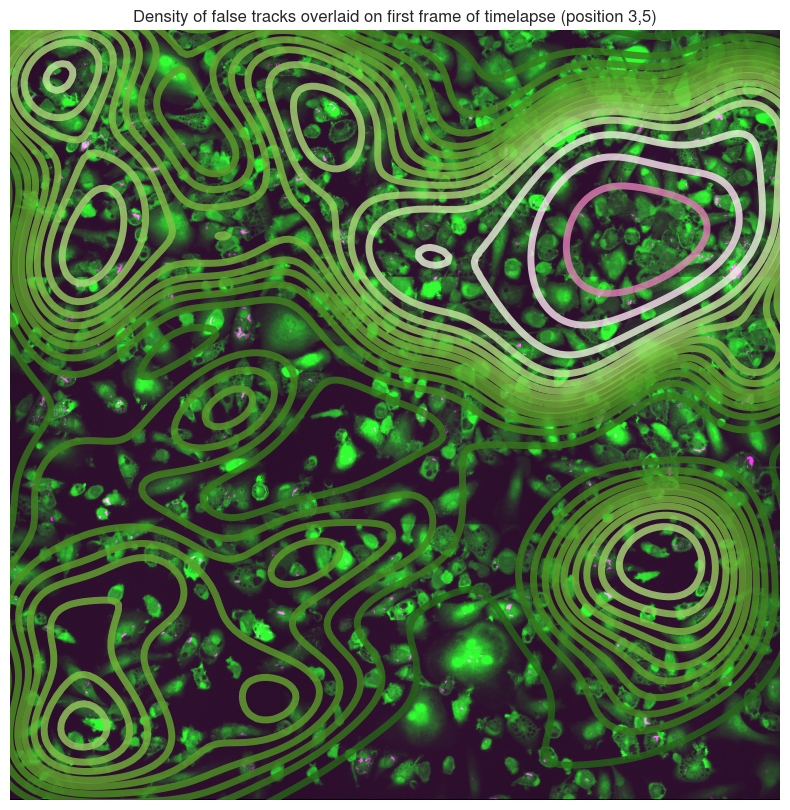

In [533]:
import matplotlib.pyplot as plt
import seaborn as sns

# # Scale the x and y coordinates by 5.04
# scaled_x_coords = [coord * 5.04 for coord in x_coords]
# scaled_y_coords = [coord * 5.04 for coord in y_coords]

# Scale the x and y coordinates by 5.04
scaled_false_x = [coord * 5.04 for coord in false_x]
scaled_false_y = [coord * 5.04 for coord in false_y]


# Set the figure size for both plots
plt.figure(figsize=(10, 10))

# Remove axis labels and tick marks
plt.axis('off')

# Load and overlay the image
image = plt.imread("/home/dayn/r03c05f0-p0-ch1sk1fk1fl1.png")
plt.imshow(np.flipud(image), extent=[0, 1200 * 5.04, 0, 1200 * 5.04], alpha=1)

# Plot the KDE density plot of cell detections (first 10 frames)
sns.kdeplot(scaled_false_x, scaled_false_y, cmap='PiYG_r', levels=15, linewidths=5, alpha=0.8)

# Set the image and KDE plot in the center
plt.xlim(0, 1200 * 5.04)
plt.ylim(0, 1200 * 5.04)

# Remove the spines
sns.despine()

# # Save the plot with a black border
# plt.savefig('/mnt/DATA/macrohet/upstream_development/tracking/tracking_performance/3,5/ground_truth_tracks/density_false_tracks_r03c05_t01_15lvls.png', 
#             bbox_inches='tight', pad_inches=0, transparent=True)

plt.title('Density of false tracks overlaid on first frame of timelapse (position 3,5)')
# Show the plot

plt.savefig(os.path.join(output_dir, 'density_false_tracks_overlay_15lvl_thicker_3,5_ground_truth.png'), 
            bbox_inches='tight', dpi=314)
plt.show()


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/tmp/ipykernel_242561/2523621803.py:48: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(os.path.join(output_dir, 'density_false_tracks_overlay_15lvl_IDs_3,5_ground_truth.png'),


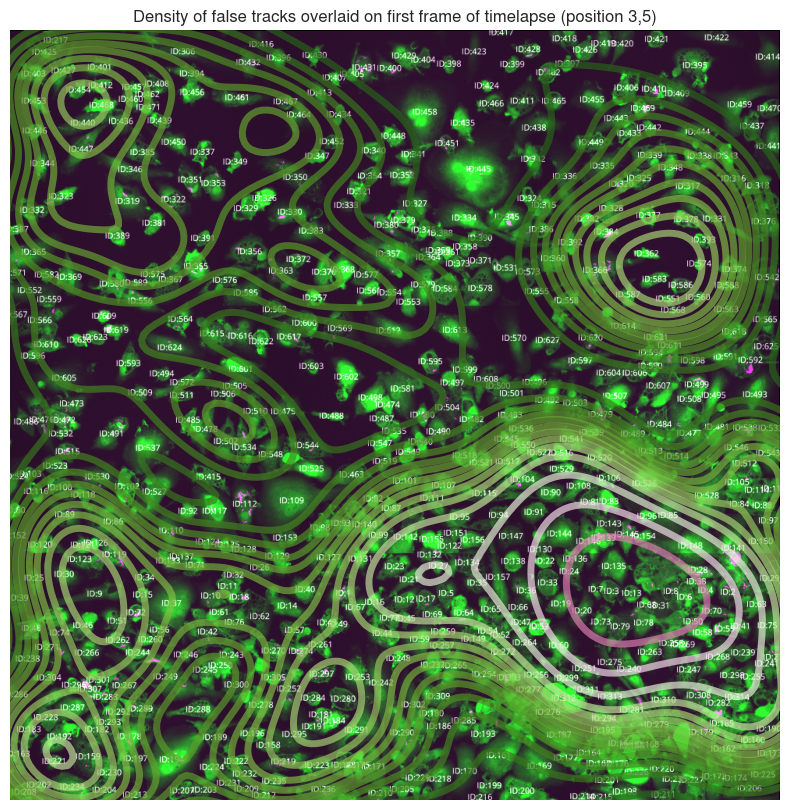

In [534]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scale the x and y coordinates by 5.04
scaled_false_x = [coord * 5.04 for coord in false_x]
scaled_false_y = [coord * 5.04 for coord in false_y]

# Set the figure size for both plots
plt.figure(figsize=(10, 10))

# Remove axis labels and tick marks
plt.axis('off')

# Load and overlay the image
image = plt.imread("/home/dayn/r03c05f0-p0-ch1sk1fk1fl1_with_IDs.png")
plt.imshow(np.flipud(image), extent=[0, 1200 * 5.04, 0, 1200 * 5.04], alpha=1)

# Plot the KDE density plot of cell detections (first 10 frames)
sns.kdeplot(scaled_false_x, scaled_false_y, cmap='PiYG_r', levels=15, linewidths=5, alpha=0.666)

# Set the image and KDE plot in the center
plt.xlim(0, 1200 * 5.04)
plt.ylim(0, 1200 * 5.04)

# Invert the y-axis
plt.gca().invert_yaxis()

# Add a black border with width 50
plt.gca().spines['top'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['right'].set_color('black')
plt.gca().spines['top'].set_linewidth(50)
plt.gca().spines['bottom'].set_linewidth(50)
plt.gca().spines['left'].set_linewidth(50)
plt.gca().spines['right'].set_linewidth(50)

# Remove the spines
sns.despine()

# # Save the plot with a black border
# plt.savefig('/mnt/DATA/macrohet/upstream_development/tracking/tracking_performance/3,5/ground_truth_tracks/density_false_tracks_r03c05_t01_15lvls_IDs.png', 
#             bbox_inches='tight', pad_inches=0, transparent=True)

plt.title('Density of false tracks overlaid on first frame of timelapse (position 3,5)')


plt.savefig(os.path.join(output_dir, 'density_false_tracks_overlay_15lvl_IDs_3,5_ground_truth.png'), 
            bbox_inches='tight', dpi=314)
# Show the plot
plt.show()


In [535]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scale the x and y coordinates by 5.04
scaled_correct_x = [coord * 5.04 for coord in correct_x]
scaled_correct_y = [coord * 5.04 for coord in correct_y]


# Set the figure size for both plots
plt.figure(figsize=(10, 10))

# Remove axis labels and tick marks
plt.axis('off')

# Load and overlay the image
image = plt.imread("/home/dayn/r03c05f0-p0-ch1sk1fk1fl1_with_IDs.png")
plt.imshow(np.flipud(image), extent=[0, 1200 * 5.04, 0, 1200 * 5.04], alpha=1)

# Plot the KDE density plot of cell detections (first 10 frames)
sns.kdeplot(scaled_correct_x, scaled_correct_y, cmap='PiYG', levels=15, linewidths=5, alpha=0.666)

# Set the image and KDE plot in the center
plt.xlim(0, 1200 * 5.04)
plt.ylim(0, 1200 * 5.04)

# Invert the y-axis
plt.gca().invert_yaxis()

# Add a black border with width 50
plt.gca().spines['top'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['right'].set_color('black')
plt.gca().spines['top'].set_linewidth(50)
plt.gca().spines['bottom'].set_linewidth(50)
plt.gca().spines['left'].set_linewidth(50)
plt.gca().spines['right'].set_linewidth(50)

# Remove the spines
sns.despine()

plt.title('Density of correct tracks overlaid on first frame of timelapse (position 3,5)')

plt.savefig(os.path.join(output_dir, 'density_correct_tracks_overlay_15lvl_IDs_3,5_ground_truth.png'), 
            bbox_inches='tight', dpi=314)
# Show the plot
plt.show()


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/tmp/ipykernel_242561/3070079005.py:44: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(os.path.join(output_dir, 'density_correct_tracks_overlay_15lvl_IDs_3,5_ground_truth.png'),


# Creating animation showing true tracks

In [476]:
true_IDs = [int(ID) for ID, status in track_performance_dict.items() if status is True]
true_tracks = [t for t in tracks if t.ID in true_IDs]

In [505]:
false_IDs = [int(ID) for ID, status in track_performance_dict.items() if status is False]
false_tracks = [t for t in tracks if t.ID in false_IDs]

In [506]:
len(true_tracks), len(false_tracks)

(384, 376)

In [477]:
true_napari_tracks, properties, graph = btrack.utils.tracks_to_napari(true_tracks, ndim=ndim)

In [ ]:
viewer.add_tracks(true_napari_tracks, scale = (1,scale_factor,scale_factor))

# Can we characterise the true tracks vs false tracks??

In [512]:
sns.set(font='Nimbus Sans', style = 'white')

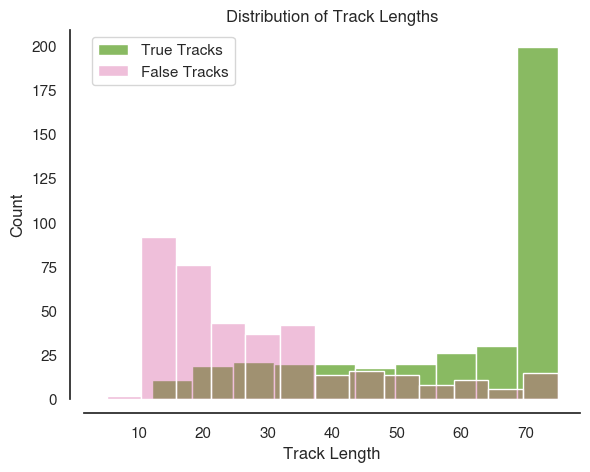

In [586]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# Calculate the track lengths for true tracks and false tracks
true_track_lengths = [len(t) for t in true_tracks]
false_track_lengths = [len(t) for t in false_tracks]

# Set the color palette for true and false tracks
colors = sns.color_palette('PiYG')

# Plot the histogram
sns.histplot(true_track_lengths, color=colors[-1], label='True Tracks')
sns.histplot(false_track_lengths, color=colors[0], label='False Tracks', alpha = 0.333)

# Add labels and title
plt.xlabel('Track Length')
plt.ylabel('Count')
plt.title('Distribution of Track Lengths')

# Remove spines and set offset
sns.despine(offset=10)

# Add legend
plt.legend()

plt.savefig(os.path.join(output_dir, 'distribution_true_false_track_lengths_3,5_ground_truth.png'), 
            bbox_inches='tight', dpi=314)

# Show the plot
plt.show()


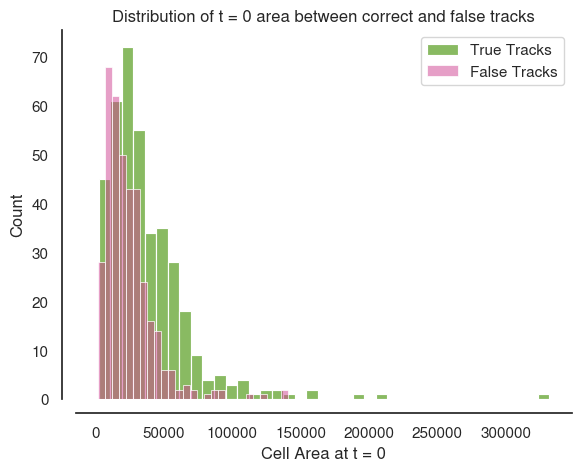

In [587]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# Calculate the track lengths for true tracks and false tracks
true_track_area_t0 = [t.properties['area'][0] for t in true_tracks]
false_track_area_t0 = [t.properties['area'][0] for t in false_tracks]

# Set the color palette for true and false tracks
colors = sns.color_palette('PiYG')

# Plot the histogram
sns.histplot(true_track_area_t0, color=colors[-1], label='True Tracks')
sns.histplot(false_track_area_t0, color=colors[0], label='False Tracks', alpha = 0.5)

# Add labels and title
plt.xlabel('Cell Area at t = 0')
plt.ylabel('Count')
plt.title('Distribution of t = 0 area between correct and false tracks')

# Remove spines and set offset
sns.despine(offset=10)

# Add legend
plt.legend()

plt.savefig(os.path.join(output_dir, 'distribution_true_false_track_areas_t0_3,5_ground_truth.png'), 
            bbox_inches='tight', dpi=314)

# Show the plot
plt.show()


In [542]:
true_tracks[0]

OrderedDict([('ID', 423), ('t', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]), ('x', [723.909912109375, 727.7713623046875, 730.8876342773438, 732.1475830078125, 730.891357421875, 731.6063842773438, 732.7880859375, 733.5286254882812, 733.5244140625, 735.2389526367188, 735.2930908203125, 737.2757568359375, 739.8804321289062, 734.8082275390625, 734.1160888671875, 732.839599609375, 732.9380493164062, 733.7298583984375, 734.4476928710938, 731.66552734375, 733.0943603515625, 732.9656982421875, 733.857666015625, 733.2906494140625, 733.9907836914062, 734.6908569335938, 731.553955078125, 727.1141967773438, 729.4885864257812, 727.8070068359375, 726.1254272460938, 724.4439086914062, 722.7623291015625, 724.7803344726562, 723.5120239257812, 722.2437744140625, 722.5082397460938, 719.0144653320312, 710.5659790039062, 717.8656005859375, 717.5695190429688, 717.2734375, 723.8037109375, 722.1908569335938, 724.8157958984375, 722.2015380859375, 720.97412109375, 714.8014526367188, 718.9297485351562, 717.9396362304688, 704.10693359375, 719.4491577148438, 717.01220703125, 714.6796875, 722.9647216796875, 723.7294921875, 716.0206909179688, 713.5088500976562, 709.8489990234375, 705.8883056640625, 710.751220703125, 711.2302856445312, 707.6941528320312, 707.5363159179688, 705.18505859375, 710.6640014648438, 704.6192016601562, 704.2034912109375, 711.9544677734375, 700.6671142578125, 698.9387817382812, 705.1088256835938, 705.6575317382812, 706.2062377929688, 702.737060546875]), ('y', [33.0101318359375, 38.2114372253418, 26.283424377441406, 27.895366668701172, 33.01917266845703, 30.63099479675293, 30.74468231201172, 27.1494083404541, 32.48095703125, 29.900726318359375, 31.338476181030273, 26.17167854309082, 22.914199829101562, 30.5830135345459, 28.87841796875, 31.859766006469727, 31.282344818115234, 38.687442779541016, 34.87721633911133, 39.415321350097656, 37.78978729248047, 43.27326583862305, 42.14923858642578, 45.4478759765625, 46.701087951660156, 47.95429992675781, 46.179344177246094, 58.06587600708008, 51.215030670166016, 50.297054290771484, 49.37907791137695, 48.46110534667969, 47.543128967285156, 53.480506896972656, 53.17506790161133, 52.86962890625, 57.44007110595703, 58.7598762512207, 70.87815856933594, 64.2750473022461, 65.2219009399414, 66.16876220703125, 53.491432189941406, 64.52392578125, 68.13816833496094, 61.609073638916016, 61.22812271118164, 62.01897048950195, 63.510807037353516, 67.58348846435547, 57.9964714050293, 57.715415954589844, 60.29514694213867, 57.0003776550293, 44.41565704345703, 52.36113739013672, 61.29521942138672, 60.11133575439453, 60.228912353515625, 62.51898193359375, 60.62214660644531, 59.85487365722656, 64.10298919677734, 60.22996520996094, 65.25172424316406, 56.914398193359375, 63.71877670288086, 62.9897575378418, 55.846309661865234, 63.19364929199219, 62.25481414794922, 61.24544906616211, 62.19169616699219, 63.137943267822266, 59.09912109375]), ('z', [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6996575593948364, 1.3993151187896729, 0.0, 0.0, 0.0, -1.5493767261505127, -3.0987534523010254, -4.648129940032959, -6.197506904602051, 0.0, -0.9735226035118103, -1.9470452070236206, 0.0, 0.0, 0.0, 0.0, 0.12443117797374725, 0.2488623559474945, 0.0, 0.0, 2.8715102672576904, 0.0, -0.9955173134803772, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.146893858909607, 0.0, 0.8544668555259705, 1.708933711051941, 0.0]), ('parent', 423), ('root', 423), ('state', [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

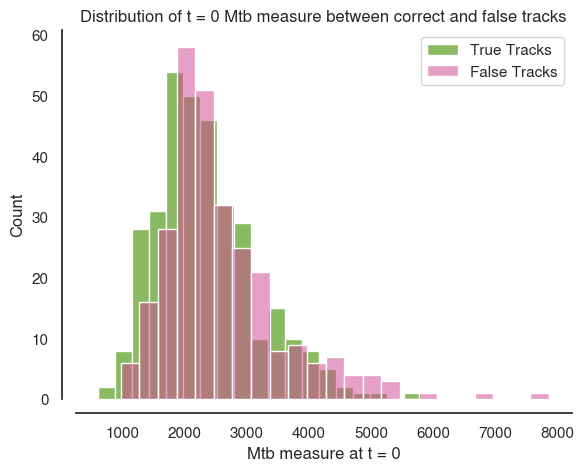

In [588]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# Calculate the track lengths for true tracks and false tracks
true_track_mtb_t0 = [t.properties['mean_intensity'][2][0] for t in true_tracks]
false_track_mtb_t0 = [t.properties['mean_intensity'][2][0] for t in false_tracks]

# Set the color palette for true and false tracks
colors = sns.color_palette('PiYG')

# Plot the histogram
sns.histplot(true_track_mtb_t0, color=colors[-1], label='True Tracks')
sns.histplot(false_track_mtb_t0, color=colors[0], label='False Tracks', alpha = 0.5)

# Add labels and title
plt.xlabel('Mtb measure at t = 0')
plt.ylabel('Count')
plt.title('Distribution of t = 0 Mtb measure between correct and false tracks')

# Remove spines and set offset
sns.despine(offset=10)

# Add legend
plt.legend()

plt.savefig(os.path.join(output_dir, 'distribution_true_false_track_mtb_t0_3,5_ground_truth.png'), 
            bbox_inches='tight', dpi=314)

# Show the plot
plt.show()


# Truer sense of tracking performance

By counting the number of cells and comparing the number of true tracks to that, rather than just hte ratio of true tracks to false which will include fragmented tracks

In [569]:
N_cells = 0
for i in range(0, 9):
    N_cells+= np.max(segmentation[i])
N_cells = N_cells/9
print(int(N_cells))

623


/tmp/ipykernel_242561/2540443389.py:59: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(os.path.join(output_dir, 'true_measure_track_performance_pie_chart_3,5_ground_truth.png'),


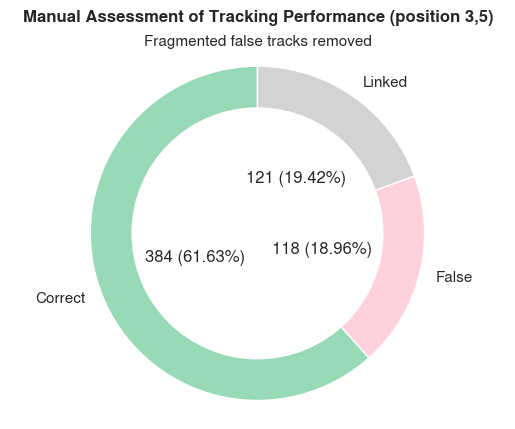

In [582]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set the theme and style
sns.set(font='Nimbus Sans', style='white')

# Assuming you have defined your track_performance_dict dictionary
correct_track_IDs = [key for key in track_performance_dict.keys() if track_performance_dict[key] == True]
false_track_IDs = [key for key in track_performance_dict.keys() if track_performance_dict[key] == False]
linked_track_IDs = [key for key in track_performance_dict.keys() if track_performance_dict[key] == 'Link']

N_cells = 0
for i in range(0, 9):
    N_cells += np.max(segmentation[i])
N_cells = N_cells / 9

N_false = N_cells - len(correct_track_IDs) - len(linked_track_IDs)

# Get counts
counts = [len(correct_track_IDs), 
          N_false,
          # len(false_track_IDs),
          len(linked_track_IDs)]

# Prepare data
categories = ['Correct', 'False', 'Linked']
colors = ['#98d9b6', '#ffd1dc', '#d3d3d3']  # Adjusted color palette 

# Plot
fig, ax = plt.subplots()

# Define autopct function to move labels into the pie
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return '{v:d}'.format(v=val) + ' ({p:.2f}%)'.format(p=pct)
    return my_format

# Draw pie chart
ax.pie(counts, labels=categories, autopct=autopct_format(counts), startangle=90, pctdistance=0.4, colors=colors)

# Draw white circle in the middle for the "donut" style
centre_circle = plt.Circle((0, 0), 0.750, fc='white')
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')  

# Change the font to Helvetica (default font in Apple Keynote)
plt.rcParams['font.family'] = 'Helvetica'

# Add title and subtitle
plt.title('Manual Assessment of Tracking Performance (position 3,5)', pad=20, weight='bold')
sns.set(font='Nimbus Sans', style='white')
plt.text(0, 1.15, 'Fragmented false tracks removed', ha='center', va='center', fontsize=11)

plt.savefig(os.path.join(output_dir, 'true_measure_track_performance_pie_chart_3,5_ground_truth.png'), 
            bbox_inches='tight', dpi=314)

plt.show() 


In [583]:
output_dir

'/mnt/DATA/macrohet/upstream_development/tracking/tracking_performance/3,5/ground_truth_tracks'

In [591]:
temp_v = napari.Viewer()

temp_v.add_image(segmentation, scale=(100,1,1))

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'segmentation' at 0x7f545172cac0>